# Malaria disease Classification using CNN in pytorch


## Datasets

We have total of a total of 27,558 images containing Infected & Uninfected data.



# Import base libraries 

In [1]:
import os
import glob
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from skimage.transform import resize
from skimage.io import imshow
%matplotlib inline

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
#https://www.fast.ai/
#fastai code snippet
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
        
def imshow_transform(image_in, title=None):
    """Imshow for Tensor."""
    img = np.rollaxis(image_in.squeeze().cpu().detach().numpy(),0,3)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    return img

# Preparing the Data
Creating PyTorch datasets to load the data.

In [3]:
base_dir = os.path.join('./data/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_data = glob.glob(infected_dir+'/*.png')
healthy_data = glob.glob(healthy_dir+'/*.png')
print (len(infected_data), len(healthy_data))


13779 13779


## Data view & Dataframe
Now, we have a balanced dataset with 13,779 malaria and 13,779 non-malaria (uninfected) cell images. 
Build a data frame from this, which is used later.


In [4]:
datafiles = infected_data + healthy_data
print (len(datafiles))

27558


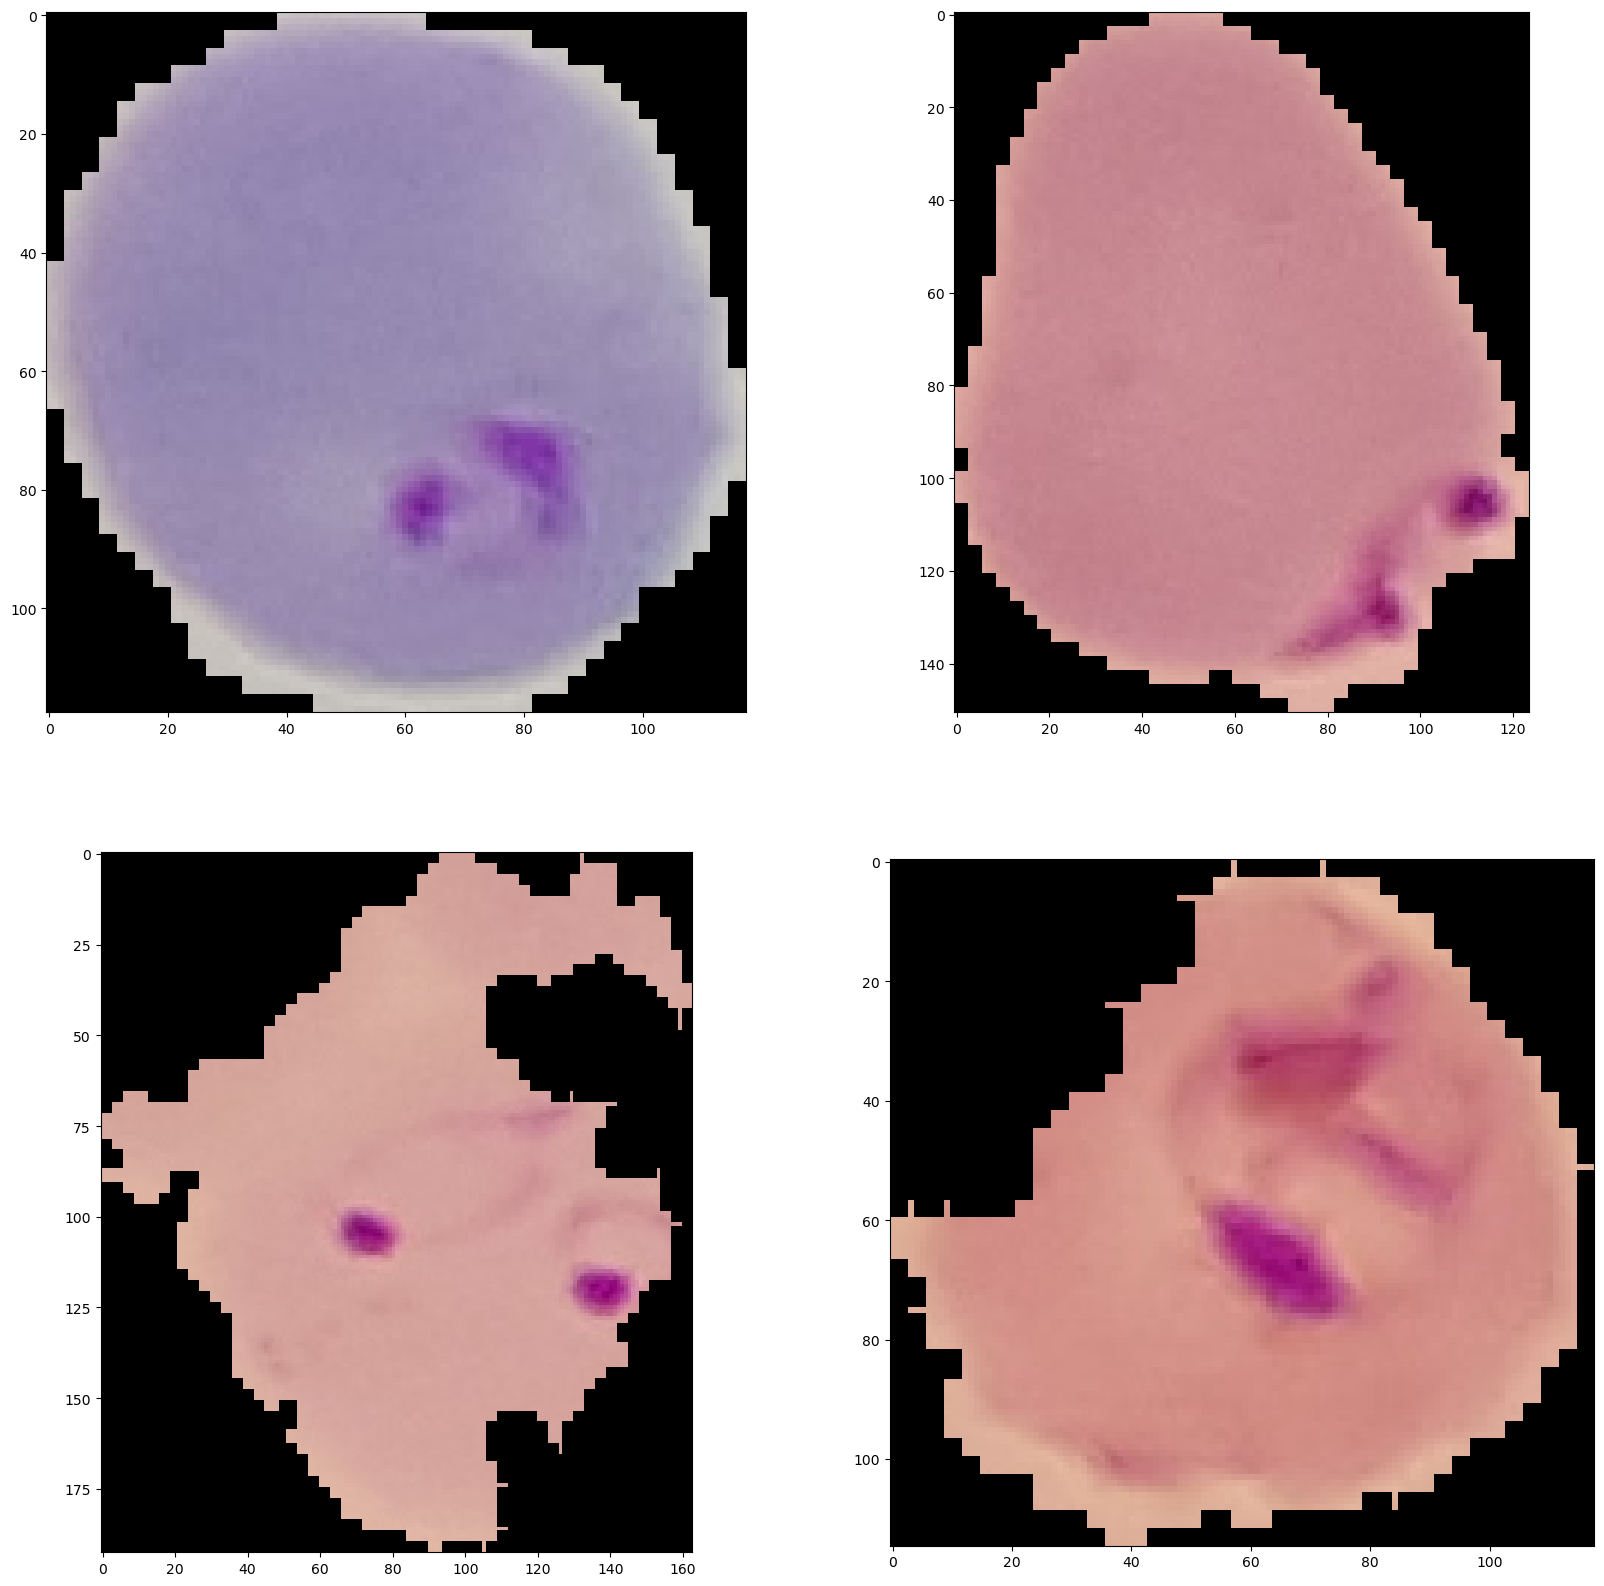

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
for i in range(4):
    img = plt.imread(datafiles[i])
    ax=axes[i//2,i%2]
    ax.imshow(img) 

# Convert images into tensors and reshaping it

In [6]:
#spiting the data into train and validation
torch.manual_seed(43)
val_size = int (len(datafiles) * 0.2)
train_size = len(datafiles) - val_size
print (train_size , val_size)

22047 5511


# Data transforms (normalization & data augmentation)

In [7]:
total_dataset = tt.Compose([tt.Resize((120,120)),
    tt.ColorJitter(0.05),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.RandomRotation(25),
    tt.ToTensor(),
    tt.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])]) ##about mean and standard deviation per channel

In [8]:
# PyTorch datasets
total_dataset = ImageFolder(base_dir, total_dataset)
train_dt, valid_dt = random_split(total_dataset, [train_size, val_size])
batch_size=128 ##define the total number of batch size
train_dataset = DataLoader(train_dt, batch_size=batch_size,shuffle=True, num_workers=3, pin_memory=True)
valid_dataset = DataLoader(valid_dt, batch_size=batch_size * 2,num_workers=3, pin_memory=True)
print("Number of batches in train set: {}\nNumber of batches in validation set: {}".format(len(train_dataset), len(valid_dataset)))

Number of batches in train set: 173
Number of batches in validation set: 22


In [9]:
def show_batch(datast):
    for imgs, labs in datast:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


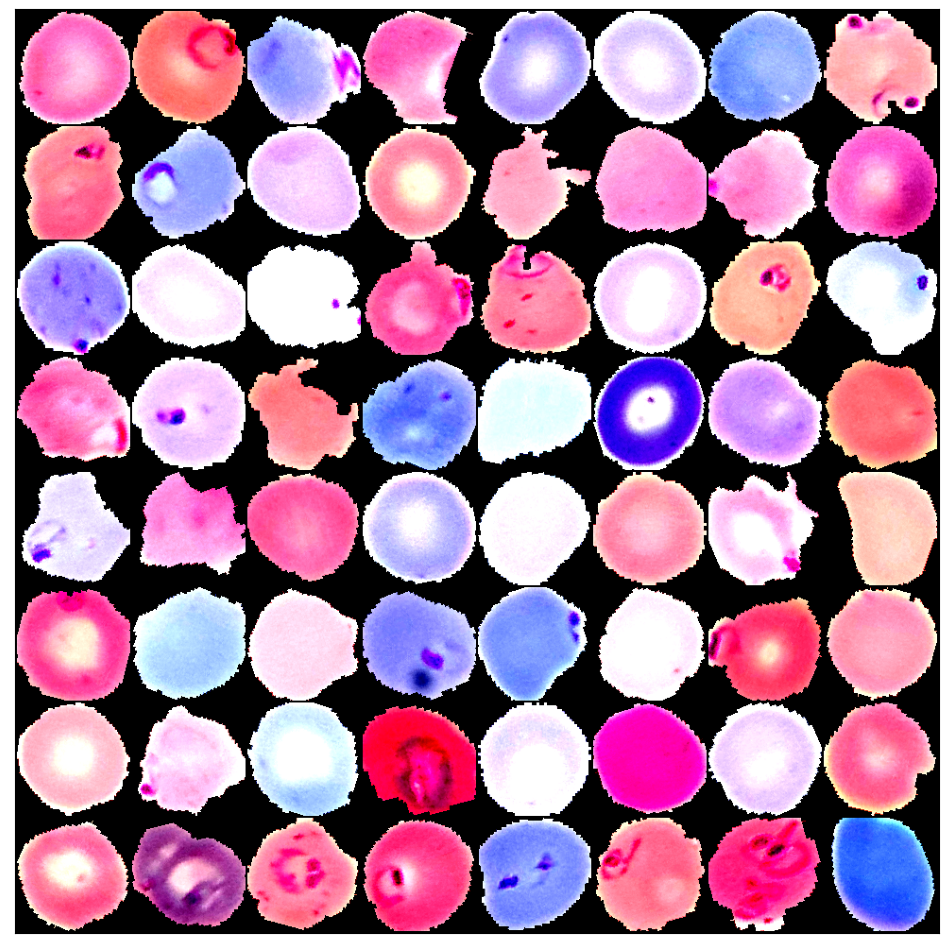

In [10]:
show_batch(train_dataset)

In [11]:
classes=['infected','uninfected']

## Using a GPU
Function to support GPU if possible

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [14]:
train_dataset = DeviceDataLoader(train_dataset, device)
valid_dataset = DeviceDataLoader(valid_dataset, device)

## Training and Validation

In [15]:
 def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
 def F_score(output, label, threshold=0.5, beta=1):
    _, prob = torch.max(output, dim=1)

    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1), 
             nn.BatchNorm2d(out_channels), 
              nn.ReLU()]
    if pool: layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

class Classification(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.layer1 = conv_block(3, 16,True)
        self.layer2 = conv_block(16,32,True)
        self.layer3 = conv_block(32, 64,True)
        self.classifier = nn.Sequential(
            nn.Linear(64*15*15, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 2),
        )
        
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)      
        loss = F.cross_entropy(out, targets)      
        return loss
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, targets) 
        acc = accuracy(out,targets)
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc,'f1_score': score}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_scores = [x['val_acc'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        batch_f1_scores = [x['f1_score'] for x in outputs]
        epoch_f1_score = torch.stack(batch_f1_scores).mean()  # Combine f1_score
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_score.item(), 'f1_score': epoch_f1_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}, val_f1_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'],result['f1_score']))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) 
        out = self.classifier(out)
        
        return out
    

In [17]:
model = Classification()
state_dict = torch.load('./malaria-cnn.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad = False
model.layer3[-4] = nn.Conv2d(32,2,kernel_size=2, padding=1)
model.layer3[-3] = nn.BatchNorm2d(2)
#remove fully connected layer and replace it with AdaptiveAvePooling
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1), Flatten(),
                                nn.Softmax()
                                )
model.to(device)


Classification(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
    (2): Softmax(dim=N

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, opt_func=torch.optim.SGD,epochs=5, lr=0.0001):
    torch.cuda.empty_cache()
    history_information = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history_information.append(result)
    return history_information

In [19]:
num_epochs = 20
optimizer = torch.optim.Adam
learning_rate = 1e-2

In [20]:
history_information = fit(model, train_dataset, valid_dataset, optimizer,num_epochs, learning_rate)

  0%|          | 0/173 [00:00<?, ?it/s]

/home/robot-os/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [0], train_loss: 0.6124, val_loss: 0.5865, val_accuracy: 0.7367, val_f1_score: 0.7610


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5698, val_loss: 0.5621, val_accuracy: 0.8109, val_f1_score: 0.8034


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5415, val_loss: 0.5515, val_accuracy: 0.8379, val_f1_score: 0.8225


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5206, val_loss: 0.5101, val_accuracy: 0.8850, val_f1_score: 0.8909


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5049, val_loss: 0.4955, val_accuracy: 0.8557, val_f1_score: 0.8678


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4912, val_loss: 0.4819, val_accuracy: 0.9049, val_f1_score: 0.9084


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4790, val_loss: 0.4712, val_accuracy: 0.8893, val_f1_score: 0.8962


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4701, val_loss: 0.4716, val_accuracy: 0.9153, val_f1_score: 0.9182


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4653, val_loss: 0.4575, val_accuracy: 0.8982, val_f1_score: 0.9031


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4564, val_loss: 0.4501, val_accuracy: 0.9089, val_f1_score: 0.9122


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4520, val_loss: 0.4575, val_accuracy: 0.8741, val_f1_score: 0.8850


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4461, val_loss: 0.4499, val_accuracy: 0.9242, val_f1_score: 0.9242


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4437, val_loss: 0.4521, val_accuracy: 0.8718, val_f1_score: 0.8832


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4371, val_loss: 0.4390, val_accuracy: 0.8912, val_f1_score: 0.8992


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4330, val_loss: 0.4308, val_accuracy: 0.9130, val_f1_score: 0.9174


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4314, val_loss: 0.4270, val_accuracy: 0.9199, val_f1_score: 0.9227


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4290, val_loss: 0.4293, val_accuracy: 0.9232, val_f1_score: 0.9236


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4262, val_loss: 0.4395, val_accuracy: 0.9093, val_f1_score: 0.9091


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4257, val_loss: 0.4186, val_accuracy: 0.9239, val_f1_score: 0.9258


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4207, val_loss: 0.4243, val_accuracy: 0.8976, val_f1_score: 0.9050


In [21]:
evaluate(model, valid_dataset)

{'val_loss': 0.4249894618988037,
 'val_acc': 0.9004339575767517,
 'f1_score': 0.9068719744682312}

## Visualizing the result

### Accuracy 

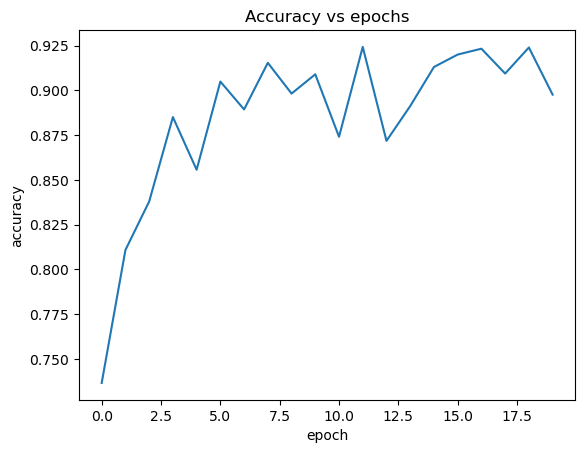

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs epochs');
plot_accuracies(history_information)

### Loss

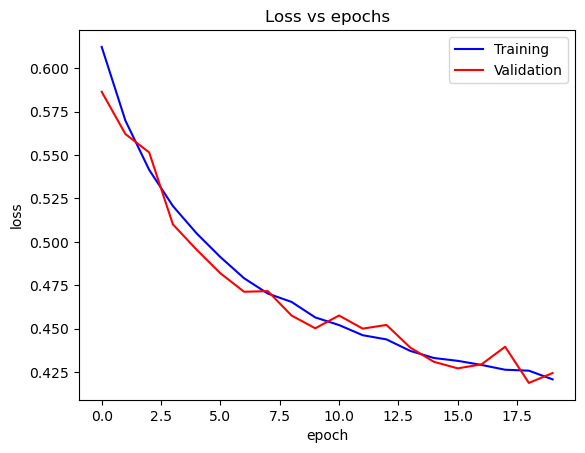

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs epochs');
plot_losses(history_information)

## Sava & Commit

In [17]:
torch.save(model.state_dict(), 'malaria-cnn_cam.pth')

NameError: name 'model' is not defined

# load the model
Visualize the class activation map in pytorch

In [18]:
model = Classification()
model.layer3[-4] = nn.Conv2d(32,2,kernel_size=2, padding=1)
model.layer3[-3] = nn.BatchNorm2d(2)
#remove fully connected layer and replace it with AdaptiveAvgPooling
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1), Flatten(),
                                nn.Softmax()
                                )
state_dict = torch.load('./malaria-cnn_cam.pth')
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Classification(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten()
    (2): Softmax(dim=N

result: infected 0


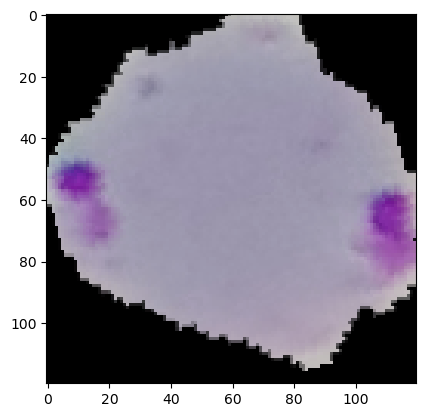

In [21]:
valid_dataset = DataLoader(valid_dt, batch_size=1,shuffle=True,num_workers=1, pin_memory=True)
#get the last convolution
lastfeature = SaveFeatures(model.layer3[-4])
#get image and label
image, label = next(iter(valid_dataset))
image = image.cuda()
label = label.cuda()
outputs = model(image)
result = torch.argmax(outputs).cpu().detach().numpy()

if result==1:
    print('result: not infected',result)
else:
    print('result: infected',result)
original_image=imshow_transform(image)

In [22]:
lastfeature.remove()
arr = lastfeature.features.cpu().detach().numpy()[0]

/home/robot-os/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


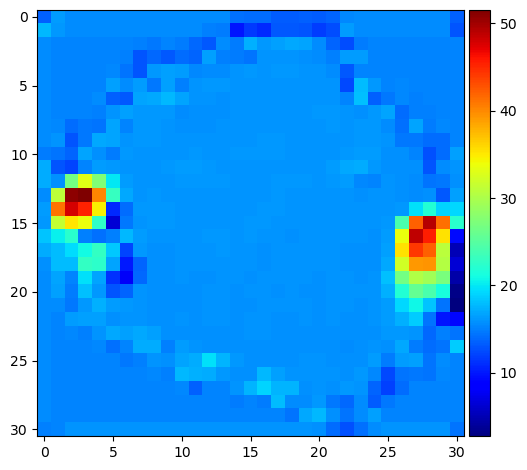

In [23]:
target=np.zeros([2,1]) ##for two classes
target[result]=1
cam_image = np.dot(np.rollaxis(arr,0,3), target)
imshow(cam_image, cmap='jet')

<Figure size 640x480 with 0 Axes>

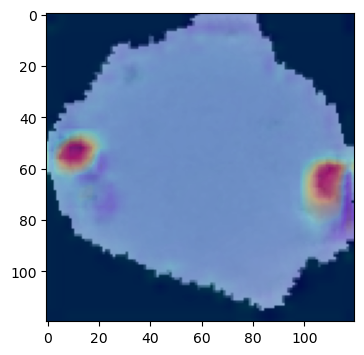

In [25]:
##resize the image and plot the cam
cam_image=resize(cam_image, (120,120))
plt.figure()
plt.subplots(figsize=(4,4))
plt.imshow(original_image)
plt.imshow(cam_image,alpha=.3, cmap='jet')
plt.show()

## References used :


Refrences :

1. https://opensource.com/article/19/4/detecting-malaria-deep-learning (using tensorflow2.0)

2. https://lhncbc.nlm.nih.gov/publication/pub9932 (original link for documentation & dataset)

3. https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce (to understsand image tranformation)

 